In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.2, 0.7])

In [4]:
h_p = -np.sum(p * np.log(p))
print("Entropia di p: ", h_p)

Entropia di p:  1.0296530140645737


In [5]:
h_pq = -np.sum(p * np.log(q))
print("Entropia incrociata tra p e q: ", h_pq)

Entropia incrociata tra p e q:  1.372238457997479


In [6]:
kl_pq = h_pq - h_p
print("Divergenza KL da p a q: ", kl_pq)

Divergenza KL da p a q:  0.34258544393290524


In [7]:
np.sum(p * (np.log(p) - np.log(q)))

0.3425854439329054

In [8]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.2, 0.55, 0.25])
np.sum(p * (np.log(p) - np.log(q)))

0.007041377136023895

In [9]:
# Define the parameters
n = 4
p = 0.2

# Compute the probability mass function
true_py = stats.binom.pmf(range(n + 1), n, p)
print(true_py)

[0.4096 0.4096 0.1536 0.0256 0.0016]


In [10]:
q1 = np.array([0.46, 0.42, 0.10, 0.01, 0.01])
print(q1)

[0.46 0.42 0.1  0.01 0.01]


In [11]:
q2 = [0.2] * 5
print(q2)

[0.2, 0.2, 0.2, 0.2, 0.2]


In [12]:
kl_pq1 = np.sum(true_py * (np.log(true_py) - np.log(q1)))
print("Divergenza KL di q1 da p: ", kl_pq1)

Divergenza KL di q1 da p:  0.02925199033345885


In [13]:
kl_pq2 = np.sum(true_py * (np.log(true_py) - np.log(q2)))
print("Divergenza KL di q2 da p: ", kl_pq2)

Divergenza KL di q2 da p:  0.4863577787141543


In [14]:
# Definire le distribuzioni p e q
p = np.array([0.01, 0.99])
q = np.array([0.7, 0.3])

# Calcolo dell'entropia di p
h_p = -np.sum(p * np.log(p))

# Calcolo dell'entropia incrociata da p a q
h_pq = -np.sum(p * np.log(q))

# Calcolo della divergenza KL da p a q
kl_pq = h_pq - h_p

# Calcolo dell'entropia di q
h_q = -np.sum(q * np.log(q))

# Calcolo dell'entropia incrociata da q a p
h_qp = -np.sum(q * np.log(p))

# Calcolo della divergenza KL da q a p
kl_qp = h_qp - h_q

print(f"Entropia di p: {h_p}")
print(f"Entropia incrociata da p a q: {h_pq}")
print(f"Divergenza KL da p a q: {kl_pq}")

print(f"\nEntropia di q: {h_q}")
print(f"Entropia incrociata da q a p: {h_qp}")
print(f"Divergenza KL da q a p: {kl_qp}")

Entropia di p: 0.056001534354847345
Entropia incrociata da p a q: 1.1954998257220641
Divergenza KL da p a q: 1.1394982913672167

Entropia di q: 0.6108643020548935
Entropia incrociata da q a p: 3.226634230947714
Divergenza KL da q a p: 2.6157699288928207


In [15]:
np.random.seed(75)

# Number of samples
n = 10000

# Draw samples from a Beta distribution
y_data = np.random.beta(1, 3, n)
print(y_data[:6])

[0.21810354 0.05532253 0.13545025 0.42102514 0.14728608 0.11052926]


In [16]:
# True distribution
def p_t(y):
    return beta.pdf(y, 1, 3)

# Predictive distribution
def p(y):
    return beta.pdf(y, 2, 2)

# Integration
def integrand(y):
    return p_t(y) * np.log(p(y))

# Perform numerical integration
result, error = quad(integrand, 0, 1)

print(result)

-0.37490719743844486


In [17]:
1 / n * np.sum(np.log(p(y_data)))

-0.3721938430299501

In [18]:
data = np.random.normal(loc=5, scale=2, size=100)
data[0:10]

array([3.64467434, 7.4467137 , 3.07761966, 7.50059139, 4.2730767 ,
       4.78830081, 7.12094138, 4.13637857, 6.53285326, 3.34258292])

In [19]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sampling from the posterior
    trace = pm.sampling_jax.sample_numpyro_nuts(1000)
    # Generating posterior predictive samples
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["y"]
    )

Compiling...


Compilation time = 0:00:01.202037


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1466.37it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.39it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.53it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.79it/s]


Sampling time = 0:00:01.699314


Transforming variables...


Transformation time = 0:00:00.068236


Sampling: [y]


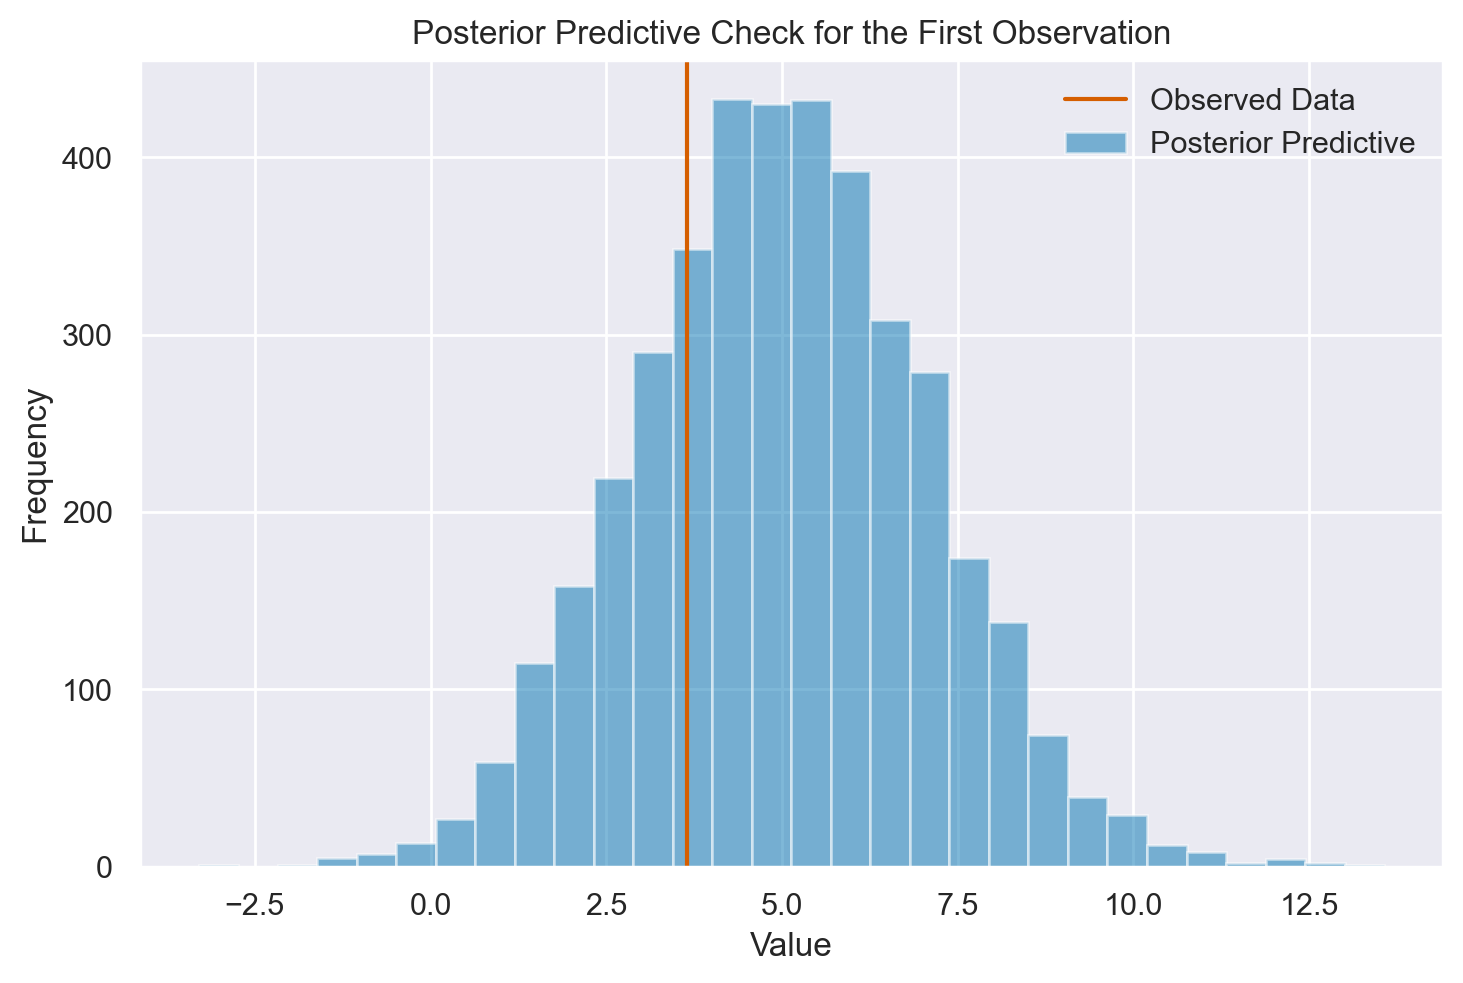

In [20]:
post_pred = ppc.posterior_predictive
y_i_post_pred = post_pred["y"].values[:, :, 0]

plt.hist(y_i_post_pred.flatten(), bins=30, alpha=0.5)
plt.axvline(data[0], color="r")
plt.title("Posterior Predictive Check for the First Observation")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(["Observed Data", "Posterior Predictive"])
plt.show()

In [21]:
y_i = data[0]
y_i

3.644674340592355

In [22]:
mu_samples = trace.posterior["mu"].values.flatten()
mu_samples[0:10]

array([4.66190347, 5.28019323, 5.06335841, 4.84006813, 4.95853181,
       4.82182767, 4.96889931, 4.86781473, 5.1638184 , 5.22770764])

In [23]:
sigma_samples = trace.posterior["sigma"].values.flatten()
sigma_samples[0:10]

array([2.10875987, 1.90287871, 1.96977262, 1.95003036, 2.10323153,
       2.13630612, 2.01019566, 2.11771452, 2.0396573 , 2.06254342])

In [24]:
pdf_values = [
    stats.norm.pdf(y_i, mu, sigma) for mu, sigma in zip(mu_samples, sigma_samples)
]

pdf_values[0:5]

[0.16840473338849557,
 0.14490541087032063,
 0.15626213197701888,
 0.16953838944649094,
 0.15605773002657994]

In [25]:
log_pdf_values = np.log(pdf_values)
log_pdf_values[0:5]

array([-1.78138507, -1.93167409, -1.85622035, -1.77467589, -1.85752928])

In [26]:
mean_log_density = np.mean(log_pdf_values)
mean_log_density

-1.8471902874526358

In [27]:
# Calcolo della densità logaritmica predittiva per ogni osservazione
all_log_densities = []
for y_i in data:
    pdf_values = [
        stats.norm.pdf(y_i, mu, sigma) for mu, sigma in zip(mu_samples, sigma_samples)
    ]
    log_pdf_values = np.log(pdf_values)
    mean_log_density = np.mean(log_pdf_values)
    all_log_densities.append(mean_log_density)

In [28]:
# Calcolo della media su tutte le osservazioni
overall_mean_log_density = np.mean(all_log_densities)
overall_mean_log_density

-2.118297396301575

In [29]:
with model:
    pm.compute_log_likelihood(trace)

In [30]:
loo_result = az.loo(trace, pointwise=True)
print(loo_result)

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -212.90     7.46
p_loo        2.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [31]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

In [32]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

In [33]:
with linear_model:
    linear_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.571930


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1437.66it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1438.34it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1439.57it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1440.47it/s]


Sampling time = 0:00:01.462414


Transforming variables...


Transformation time = 0:00:00.041977


Computing Log Likelihood...


Log Likelihood time = 0:00:00.110928


In [34]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)

In [35]:
with intercept_model:
    intercept_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.215750


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2184.99it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2186.96it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2190.28it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2193.14it/s]


Sampling time = 0:00:00.955375


Transforming variables...


Transformation time = 0:00:00.026908


Computing Log Likelihood...


Log Likelihood time = 0:00:00.062672


In [36]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.63     6.93
p_loo        2.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [37]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2252.88   195.98
p_loo       44.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       99   99.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [38]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.629669,2.921481,0.000000,1.000000e+00,6.928616,0.000000,False,log
intercept_model,1,-2252.880972,44.208943,2008.251303,3.623768e-10,195.980227,195.618869,False,log


/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


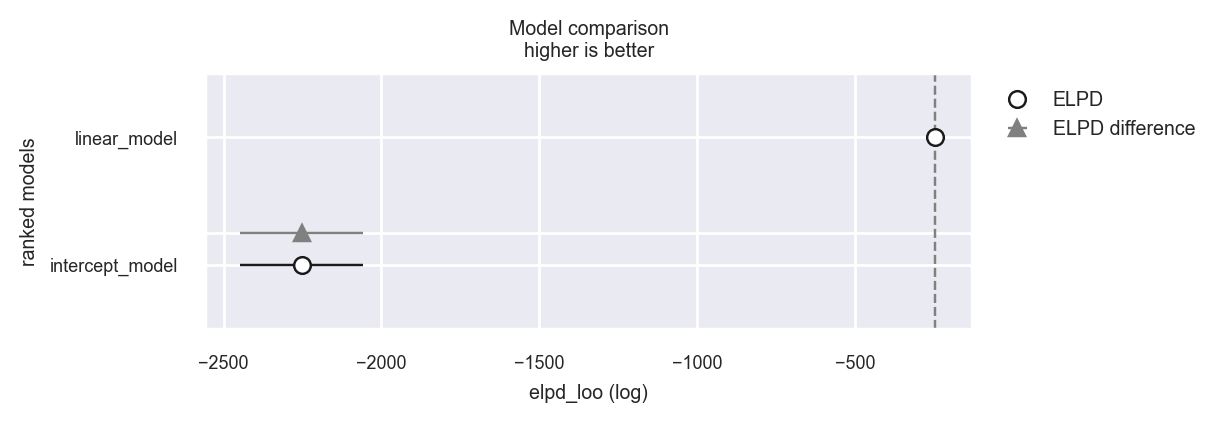

In [39]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 25 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

seaborn    : 0.13.0
arviz      : 0.17.0
pymc       : 5.10.3
numpy      : 1.26.2
scipy      : 1.11.4
pandas     : 2.1.4
statsmodels: 0.14.1
matplotlib : 3.8.2

Watermark: 2.4.3

